<a href="https://colab.research.google.com/github/ABD-01/MNIST/blob/main/Triplet%20Loss/TRIPLET_LOSS_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
 
import tensorflow as tf
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
 
import torchvision
import torchvision.transforms as transforms

In [2]:
# plt.rcParams['figure.figsize'] = (5, 5)

### Triplet Loss

In [32]:
def triplet_loss(anchor, positive, negative, margin=0.2):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/0c719f9e8f59fa386e8c59d10b2ddde9fac46276/losses.py#L24

In [4]:
def tf_triplet_loss(anchor, positive, negative, margin=0.2):    
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    loss = tf.maximum(pos_dist - neg_dist + margin, 0)
    return tf.reduce_mean(loss)
 
# ref : https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow/38270293#38270293

In [5]:
torch_triplet_loss = nn.TripletMarginLoss(margin=0.2)

In [6]:
MNIST_train = torchvision.datasets.MNIST(
    root = '/content/drive/MyDrive/Colab Notebooks/',
    download = True,
    train = True,
    transform = transforms.Compose([transforms.ToTensor()])
)

4

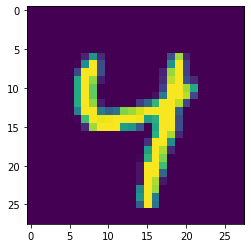

In [7]:
i =5734
plt.imshow(MNIST_train[i][0].squeeze())
MNIST_train[i][1]

## Reorganizing Data

In [8]:
train_dict = {i : MNIST_train.data[MNIST_train.targets == i].unsqueeze(1) / 255 for i in range(10)}
print(*[f'{len(imgs)} images of Label {label}' for label, imgs in train_dict.items()], sep='\n')
# for i in range(10):
#     train_dict[i] = MNIST_train.data[MNIST.targets == i]

5923 images of Label 0
6742 images of Label 1
5958 images of Label 2
6131 images of Label 3
5842 images of Label 4
5421 images of Label 5
5918 images of Label 6
6265 images of Label 7
5851 images of Label 8
5949 images of Label 9


In [9]:
label = 7
rand_imgs = train_dict[label][random.sample(range(1, 5000), 100)]
grid = torchvision.utils.make_grid(rand_imgs, nrow=10, pad_value=20)
# ref: https://pytorch.org/vision/stable/utils.html#torchvision-utils

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


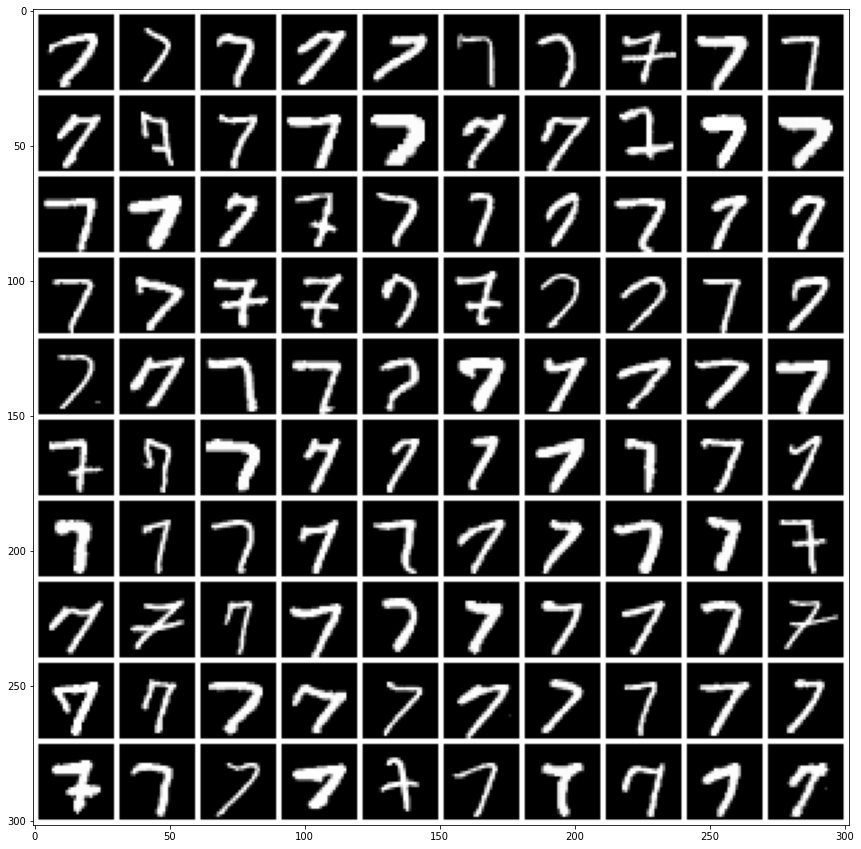

In [10]:
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

In [11]:
28*28

784

Image Processing 

In [12]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda image: torch.cat((image,image,image), dim=-3)),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=0.449, std=0.225),
])
# ref: https://pytorch.org/hub/pytorch_vision_resnet/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


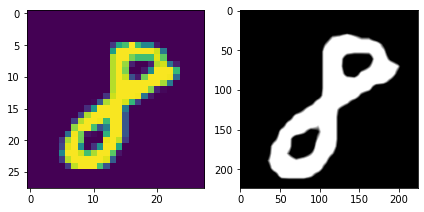

In [13]:
timg = train_dict[8][1]  # shape = (1,28,28)
ptimg = preprocess(timg)  # shape = (3,224,224)

_, axarr = plt.subplots(1,2, figsize = (7,7)) 

axarr[0].imshow(timg.squeeze())

axarr[1].imshow(torch.movedim(ptimg, -3, -1))
#ref : https://pytorch.org/docs/stable/generated/torch.movedim.html

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


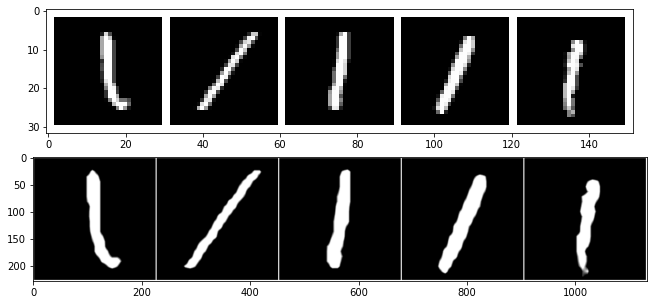

In [14]:
rand_imgs = train_dict[1][random.sample(range(1, 5000), 5)]  # shape = (5,1,28,28)
grid = torchvision.utils.make_grid(rand_imgs, nrow=5, pad_value=20)

prand_imgs = preprocess(rand_imgs)  # shape = (5,3,224,224)
pgrid = torchvision.utils.make_grid(prand_imgs, nrow=5, pad_value=20)

fig , axarr = plt.subplots(2,1, figsize = (15,5)) 

axarr[0].imshow(np.transpose(grid, (1,2,0)))
axarr[1].imshow(np.transpose(pgrid, (1,2,0)))

In [33]:
resnet18 = torchvision.models.resnet18(pretrained=True)

In [ ]:
resnet18.modules

In [34]:
def model(images):
    images = preprocess(images)
    return resnet18(images)

In [35]:
encoding_dict = {}
for i in range(5):
    encoding_dict[i] = model(train_dict[i][:10])

In [19]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']
 
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(3):
        plt.scatter(embeddings[i].detach().numpy()[:,:500],embeddings[i].detach().numpy()[:,500:], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(targets)

In [20]:
label = 0
rand_encd0 = encoding_dict[0][random.sample(range(1, 10), 5)]
rand_encd1 = encoding_dict[1][random.sample(range(1, 10), 5)]
rand_encd2= encoding_dict[2][random.sample(range(1, 10), 5)]

In [21]:
[rand_encd0, rand_encd1,rand_encd2][0].shape

torch.Size([5, 1000])

In [22]:
rand_encd0.shape

torch.Size([5, 1000])

In [31]:
triplet_loss(rand_encd0[0], rand_encd0[1], rand_encd1[0])

tensor(0.2994, grad_fn=<MeanBackward0>)

In [24]:
(rand_encd0[0] - rand_encd0[1]).pow(2).sum(-1).pow(.5)

tensor(3.2796, grad_fn=<PowBackward0>)

In [25]:
(rand_encd0[0] - rand_encd1[0]).pow(2).sum(-1).pow(.5)

tensor(3.1802, grad_fn=<PowBackward0>)

In [29]:
torch_triplet_loss(rand_encd0[0].unsqueeze(0), rand_encd0[1].unsqueeze(0), rand_encd1[0].unsqueeze(0))

tensor(0.2994, grad_fn=<MeanBackward0>)

In [ ]:
def

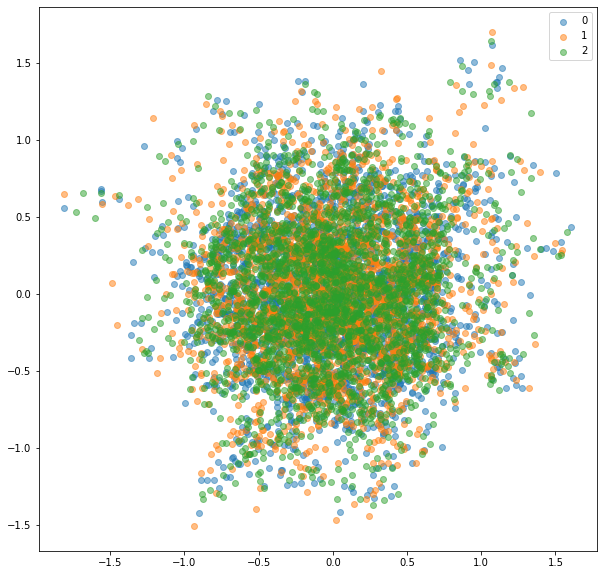

In [27]:
plot_embeddings([rand_encd0, rand_encd1,rand_encd2], [0,1,2])

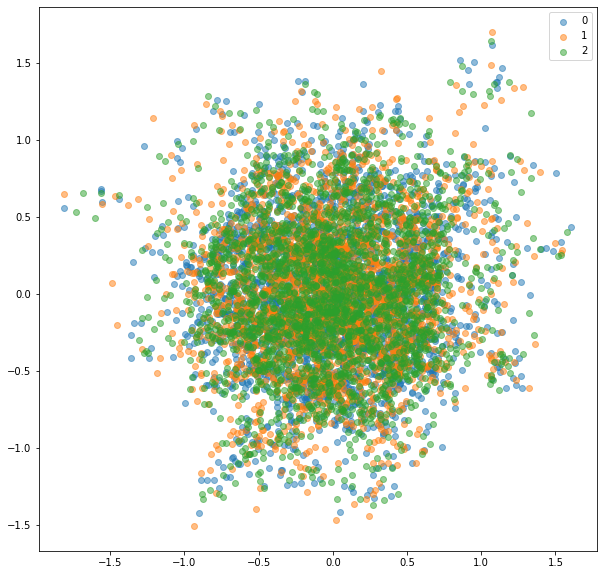

In [36]:
plot_embeddings([rand_encd0, rand_encd1,rand_encd2], [0,1,2])